In [9]:
from keras.models import load_model
from gensim.parsing.preprocessing import preprocess_documents
import pandas as pd
import numpy as np

model = load_model('../input/dataset/model-31.h5')
mlcq_train_df = pd.read_csv('../input/dataset/mlcq_train_df.csv')
mlcq_test_df = pd.read_csv('../input/dataset/mlcq_test_df.csv')

In [10]:
# preprocessing
mlcq_train_df['long_method_detected'] = mlcq_train_df['severity'].apply(
    lambda x: 1 if x == 'critical' or x == 'major' or x == 'minor' else 0)

mlcq_test_df['long_method_detected'] = mlcq_test_df['severity'].apply(
    lambda x: 1 if x == 'critical' or x == 'major' or x == 'minor' else 0)

In [11]:
def remove_leading(snippet):
    ret = ''
    for line in snippet.split('\n'):
        ret += line.lstrip() + '\n'
    return ret

def force_ascii(string):
    encoded_string = string.encode('ascii', 'ignore')
    return encoded_string.decode()

def extract_clean_body(raw_snippet):
    encoded_string = raw_snippet.encode('ascii', 'ignore')
    cleaned = remove_leading(encoded_string.decode())
    
    # remove double newlines, critical!!
    len_before = len(cleaned)
    tmp = cleaned.replace('\n\n','\n')
    len_after = len(tmp)
    while len_after < len_before:
        len_before = len(tmp)
        tmp = tmp.replace('\n\n', '\n')
        len_after = len(tmp)
        
    cleaned = tmp
    
    # select only body
    start = cleaned.find('{')
    end = cleaned.rfind('}')
    
    return cleaned[start + 1:end].strip()

def predict(code_snippet, threshold = 0.5):
    assert 0. <= threshold <= 1.
    
    if type(code_snippet) == float:
        print(code_snippet)
    
    pattern = [ord(char) for char in code_snippet]
    empty = 100 - len(pattern) % 100
    
    for i in range(empty):
        pattern.append(ord(' '))
    
    pattern = np.array(pattern)
    
    #TODO: pass model
    probs = model.predict(pattern.reshape(-1, 100)).flatten()
    preds = (model.predict(pattern.reshape(-1, 100)) > threshold)
    totalLogBlocks = preds.sum() + 1
    
    newline_vec = []
    
    for i in range(len(pattern)):
        if pattern[i] == ord('\n'):
            newline_vec.append(probs[i])
    
    return totalLogBlocks, preds, pattern, newline_vec

def extract_logical_blocks(snippet, prediction_threshold = .4):
    num, preds, pattern, _ = predict(snippet, prediction_threshold)
    
    preds_flatten = preds.flatten()
    indices = [0] + list(np.argwhere(preds_flatten == True).flatten())
    blocks = [pattern[i:j] for i,j in zip(indices, indices[1:]+[None])]
    
    decoded_blocks = []
    
    for coded_block in blocks:
        decoded_blocks.append(''.join([chr(ci) for ci in coded_block]))
    
    return decoded_blocks

In [12]:
mlcq_train_df['clean_body'] = mlcq_train_df['snippet'].apply(
    lambda x: extract_clean_body(x))

mlcq_test_df['clean_body'] = mlcq_test_df['snippet'].apply(
    lambda x: extract_clean_body(x))

In [13]:
from functools import reduce
import math

stop_words = 'abstract continue for new switch assert default goto package synchronized boolean do if private this break double implements protected throw byte else import public throws case enum instanceof return transient catch extends int short try char final interface static void class finally long strictfp volatile const float native super while'
stop_words_list = stop_words.split()

def encode(doc, dictionary):
    result = []
    #doc = doc.lower().split(' ')
    doc = preprocess_documents([doc])[0]
    for w in dictionary:
        result.append(doc.count(w))
    return np.asarray(result)

def detect_long_method(documents, alpha=.4, k=None):
    if len(documents) == 1:
        return 0
    
    dictionary = sorted(filter(lambda x: x not in stop_words_list, list(set(reduce(lambda x, y: x + y, preprocess_documents(documents))))))
    
    if len(dictionary) == 0:
        return 0
    
    A = np.array([encode(doc, dictionary) for doc in documents])
    A = A.reshape(-1, len(documents))
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    
    k = len(s) - 1 # len(documents) - 1 #rodo: tweak
    assert k > 0
    Uk = u[:,0:k]
    Sk = (np.eye(len(s)) * s)[0:k,0:k]
    VkT = vh[0:k,:] #transpose no, wa?
    
    #print(len(documents), A.shape, 'U=', Uk.shape, 'S=', Sk.shape, 'V=', vh.shape, 'VkT=', VkT.shape)
    #return
    
    for i in range(len(documents)):
        q = encode(documents[i], dictionary)
        q = q @ Uk @ np.linalg.pinv(Sk)
        for j in range(len(documents)):
            #print(len(documents), VkT.shape, q.shape, VkT[:,j].shape, len(dictionary))
            # WARNING
            if i != j and cosine_similarity(q,VkT[:,j]) < alpha:
                return 1
    return 0

def cosine_similarity(q, d):
    return q @ d / (np.linalg.norm(q) * np.linalg.norm(d))

100%|██████████| 6/6 [31:19<00:00, 313.25s/it]


<AxesSubplot:xlabel='granulation', ylabel='score'>

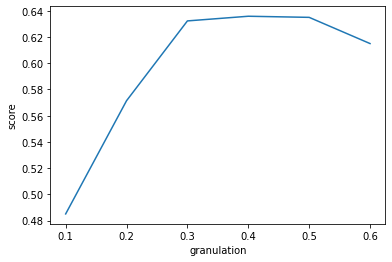

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
# best gran

run_stats = {
    'granulation': [],
    'score': []
}

granulation = 0.1

for i in tqdm(range(6)): #len(target_columns)
    mlcq_train_df['logical_blocks'] = mlcq_train_df['clean_body'].apply(
    lambda snippet: extract_logical_blocks(snippet, granulation))

    X_t = mlcq_train_df['logical_blocks'] # logical blocks aka documents
    y_t = mlcq_train_df['long_method_detected']
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
    
    #y_pred = X.apply(lambda documents: count_long_method(documents))
    y_pred = X_t.apply(lambda documents: detect_long_method(documents))
    score = f1_score(y_t, y_pred)
        
    run_stats['granulation'].append(granulation)
    run_stats['score'].append(score)
    
    granulation += .1
    

sns.lineplot(data=pd.DataFrame.from_dict(run_stats), x='granulation', y='score')

In [15]:
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns


#mlcq_train_df['logical_blocks'] = mlcq_train_df['clean_body'].apply(
#    lambda snippet: extract_logical_blocks(snippet, .6))

mlcq_test_df['logical_blocks'] = mlcq_test_df['clean_body'].apply(
    lambda snippet: extract_logical_blocks(snippet, .4))

In [16]:
from sklearn.metrics import classification_report

#X_train = mlcq_train_df['logical_blocks']
#y_train = mlcq_train_df['long_method_detected']

X_test = mlcq_test_df['logical_blocks']
y_test = mlcq_test_df['long_method_detected']

y_pred = X_test.apply(lambda documents: detect_long_method(documents))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       428
           1       0.54      0.65      0.59        54

    accuracy                           0.90       482
   macro avg       0.75      0.79      0.77       482
weighted avg       0.91      0.90      0.90       482



In [17]:
X_train = mlcq_train_df['clean_body'].apply(lambda snippet: predict(snippet, .5)[3])
X_test = mlcq_test_df['clean_body'].apply(lambda snippet: predict(snippet, .5)[3])

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# padding
dim = 0
X_train_padded = []
X_test_padded = []

for i in X_train:
    dim = max(dim, len(i))

for i in X_train:
    sample = i + [0] * (dim - len(i))
    X_train_padded.append(sample)

for i in X_test:
    sample = i + [0] * (dim - len(i))
    X_test_padded.append(sample)
    
X_train_padded = np.array(X_train_padded)
X_test_padded = np.array(X_test_padded)

In [19]:
X_train_padded.shape, X_test_padded.shape

((1926, 404), (482, 404))

In [20]:
# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

y_train = mlcq_train_df['long_method_detected']

parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 10]}

svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_padded, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf', 'sigmoid')})

In [21]:
print(clf.best_estimator_, clf.best_score_)

y_pred = clf.predict(X_test_padded)
print(classification_report(y_test, y_pred))

SVC(C=1, kernel='linear') 0.9397725590471705
              precision    recall  f1-score   support

           0       0.94      1.00      0.96       428
           1       0.93      0.46      0.62        54

    accuracy                           0.94       482
   macro avg       0.93      0.73      0.79       482
weighted avg       0.94      0.94      0.93       482



In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': list(range(1, 100)), 'max_depth': list(range(1, 20))}

forest = RandomForestClassifier(random_state=3211)

clf = GridSearchCV(forest, parameters)
clf.fit(X_train_padded, y_train)

print(clf.best_estimator_, clf.best_score_)

y_pred = clf.predict(X_test_padded)
print(classification_report(y_test, y_pred))

In [ ]:
y_pred = clf.predict(X_test_padded)
print(classification_report(y_test, y_pred))